## map2loop: South Australia

<img src='../graphics/loop_sm.png'>
   
   This notebook allows you to select a rectangular sub-area in South Australia, Australia, and using <a href="http://www.energymining.sa.gov.au/minerals/geoscience/geological_survey" target="_blank">SA</a>  geology polygons, bedding orientation data and fault polylines, calculates the topological relationships between the different features. All the data is Open Access and is served on a Loop WFS server.

This all gets fed into successive tolopogical and geometric transfroms that end up feeding into a mdelling engine to make a 3D model.  

For this map there is a mixing of Formations, Groups and Supergroups for the polygins, so I manually edited the shapefile to make it more coherent. Ned to think how to do this automatically. Also defined relative stratigrpahy manually.

<font color='red'>The leaflet version here dangerously allows you to select your own area from the map, this is just for showing off, as in many parts of SA, the area we focus on here, there isn't enough data in the map alone to make a decent 3D model</font>   

The outputs from this notebook can be fed into gempy, LoopStructural, Geomodeller and, for the faults, noddy. Having some data doen't mean that you will get a reasonable model for three reasons:
   
1) The map is itself a model, and it may be wrong, or internally inconsistent  

2) map2loop may have stuffed up   

3) The modelling algorithm may be too simple to accept all the data, or to build a geologically reasonable model with even good data.   

Codes here were developed as part of the <a href="https://loop3d.org/">Loop</a> | <a href="https://minexcrc.com.au/"> MinEx CRC</a> | <a href="https://www.darecentre.org.au/">DARE</a> partnerships with export codes drawing heavily on the expertise of Miguel de la Varga (<a href="https://github.com/cgre-aachen/gempy">gempy</a>), Lachlan Grose (Loop Structural, coming soon!), Des FItzgerald (<a href="https://www.intrepid-geophysics.com/product/geomodeller/Geomodeller">Geomodeller</a>) and Florian Wellmann & Noe Pollack (<a href="https://github.com/cgre-aachen/pynoddy">pynoddy</a>).

### Instructions:   
1) Select a pre-defined example area or draw your own rectangular area from map below, in an area with some bedding data (red dots). *I advise you start off with the examples, then near where the map open ups below, the further you stray, the harder it gets! Also don't draw too large a rectangle (50km x 50km), yes I know it needs a scale bar*  
   
2) Select a target modelling engine (loopstructural, gempy, geomodeller, noddy)   

3) Run all code below that and post an issue at <a href="https://github.com/Loop3D/map2loop/issues">github</a> when it crashes   

#### If not already available, the notebook will first download a 6 MB data package to set things up, this may take a few minutes, depending on your network speed. Once downloaded, this will not need to happen again (unless you delete the NT directory)

In [67]:
from zipfile import ZipFile
import os
from urllib.request import urlopen
from io import BytesIO

if(not os.path.isdir('../SA/data')):

    with urlopen('http://geo.loop-gis.org/files/SAdata.zip') as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall('../SA/')

In [68]:
import ipywidgets as widgets
import os

# load last saved map area and mdoe engine (if they exist)
if(not os.path.isdir('../scratch/')):
    os.mkdir('../scratch/')
if(os.path.isfile('../SA/last_choices.txt')):
    f=open('../SA/last_choices.txt','r')
    contents =f.readlines()
    f.close()
    default_map=contents[0].replace("\n","")
    default_engine=contents[1].replace("\n","")
else:
    default_map='Turner_Syncline'
    default_engine='loopstructural'

options=['Draw Your Own','Last Area Drawn']

if(not default_map in options):
    default_map= options[0]

map_choice=widgets.Dropdown(
    options=options,
    value=default_map,
    description='Map area:',
    disabled=False,
)
display(map_choice)

Dropdown(description='Map area:', index=1, options=('Draw Your Own', 'Last Area Drawn'), value='Last Area Draw…

In [69]:
test_data_name=map_choice.value
print(test_data_name)
if(not test_data_name =='Draw Your Own' and not test_data_name =='Last Area Drawn'):
    test_data_path='../'+test_data_name+'/'

    os.chdir(test_data_path)
    print(os.getcwd())    
    %run -i "m2l_config.py"


Last Area Drawn


In [70]:
import folium
import pandas as pd
import json
import random
from shapely.geometry import Polygon
from ipyleaflet import Map, basemaps, GeoJSON, LayersControl, DrawControl,WMSLayer, GeoData
from ipywidgets import Label
from ipywidgets import Label
import ipywidgets as widgets
import geopandas as gpd


if(not test_data_name =='Draw Your Own'):
    if(test_data_name=='Last Area Drawn'):
        last_coords=pd.read_csv('../SA/last_area.csv')
        display(last_coords)
        minx=last_coords.iloc[0]['minx']
        miny=last_coords.iloc[0]['miny']
        maxx=last_coords.iloc[0]['maxx']
        maxy=last_coords.iloc[0]['maxy']
    src_crs = "epsg:4326"  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
    dst_crs = "epsg:28354"  # coordinate reference system for imported dtms (geodetic lat/long WGS84)

    bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
    y_point_list = [miny, miny, maxy, maxy, maxy]
    x_point_list = [minx, maxx, maxx, minx, minx]
    bbox_geom = Polygon(zip(x_point_list, y_point_list))
    polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom])
    polygon_ll=polygon.to_crs(src_crs)

    minlong=polygon_ll.total_bounds[0]
    maxlong=polygon_ll.total_bounds[2]
    minlat=polygon_ll.total_bounds[1]
    maxlat=polygon_ll.total_bounds[3]
    
    minlong=minx
    maxlong=maxx
    minlat=miny
    maxlat=maxy

    lat_point_list = [minlat, minlat, maxlat, maxlat,maxlat]
    lon_point_list = [minlong, maxlong, maxlong, minlong, minlong]
    bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
    rect = gpd.GeoDataFrame(index=[0], crs=src_crs, geometry=[bbox_geom]) 

    example_rect = GeoData(geo_dataframe = rect,
                   style={'color': 'purple', 'opacity':3, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},                  
                   name = 'Example')
    center=(minlat+((maxlat-minlat)/2),minlong+((maxlong-minlong)/2))
else:
    center=(-33.5,138.7)
    
wms_warox = WMSLayer(
    url='http://geo.loop-gis.org/geoserver/GSSA/wms?',
    layers='GSSA:sth_flinders',
    format='image/png',
    transparent=True,
    attribution='Outcrop data from GSSA',
    name='outcrops'

)
wms_geol = WMSLayer(
    url='http://geo.loop-gis.org/geoserver/GSSA/wms?',
    layers='GSSA:2m surface geology',
    format='image/png',
    transparent=True,
    opacity=0.4,
    attribution='Geology data from GSSA',
    name='geology'

)
m =Map(basemap=basemaps.OpenTopoMap, center=center, zoom=9,scroll_wheel_zoom=True)
label = Label()
display(label)

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label.value = str(kwargs.get('coordinates'))

m.on_interaction(handle_interaction)
m.add_layer(wms_geol)
m.add_layer(wms_warox)
if(not test_data_name =='Draw Your Own'):
    m.add_layer(example_rect)


m.add_control(LayersControl())
dc = DrawControl(rectangle={'shapeOptions': {'color': '#0000FF'}})
m.add_control(dc)
m

,minx,miny,maxx,maxy
0,138.613411,-33.582957,139.050709,-33.068466


Label(value='')

Map(center=[-33.325711706575504, 138.83206022115678], controls=(ZoomControl(options=['position', 'zoom_in_text…

## If you don't see a map above, please uncomment the next two lines of code
   
So they should look like this:   

!conda install -c conda-forge ipyleaflet -y   
!jupyter nbextension enable --py --sys-prefix ipyleaflet   


In [71]:
#!conda install -c conda-forge ipyleaflet -y
#!jupyter nbextension enable --py --sys-prefix ipyleaflet


In [72]:
if(test_data_name=='Draw Your Own' or test_data_name=='Last Area Drawn'):
    if(test_data_name=='Draw Your Own'):
        new_poly=GeoJSON(data=dc.last_draw)
        new_poly=str(new_poly)

        if("'geometry': None" in new_poly):
            raise NameError('map2loop error: No rectangle selected')
        new_poly=new_poly.rsplit("'coordinates': ", 1)[1]
        new_poly=new_poly.replace('[[[','').replace('[','').replace(']]]}})','').replace('],','').replace(',','').split(" ")
        longs=new_poly[0::2]
        lats=new_poly[1::2]
        minlong=float(min(longs))
        maxlong=float(max(longs))
        minlat=float(max(lats)) #ignores sign
        maxlat=float(min(lats)) #ignores sign
        
    bounds=(minlong,maxlong,minlat,maxlat)
    src_crs = "epsg:4326"  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
    dst_crs = "epsg:28354" # coordinate system for example data


    lat_point_list = [minlat, minlat, maxlat, maxlat,maxlat]
    lon_point_list = [minlong, maxlong, maxlong, minlong, minlong]
    bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
    mbbox = gpd.GeoDataFrame(index=[0], crs=src_crs, geometry=[bbox_geom]) 
    print(src_crs,mbbox.total_bounds)
    mbbox=mbbox.to_crs(dst_crs)
    print(dst_crs,mbbox.total_bounds)
    
    f=open('../SA/last_area.csv','w') 
    ostr='minx,miny,maxx,maxy\n'
    f.write(ostr)
    ostr=str(minlong)+','+str(minlat)+','+str(maxlong)+','+str(maxlat)+'\n'
    f.write(ostr)
    f.close()
    

epsg:4326 [138.61341098 -33.58295709 139.05070946 -33.06846632]
epsg:28354 [ 277200.88172686 6281530.79977633  319098.6616706  6339433.44949636]


## Choose model engine
1. Run cell below
2. Select modelling engine from drop down menu   
3. Click in next cell and run to end using menu: *Cell->Run all below* 

In [73]:
engine_choice=widgets.Dropdown(
    options=['geomodeller', 'gempy','loopstructural','noddy','null'],
    value=default_engine,
    description='Modeller:',
    disabled=False,
)
display(engine_choice)



Dropdown(description='Modeller:', index=2, options=('geomodeller', 'gempy', 'loopstructural', 'noddy', 'null')…

In [74]:
workflow={'model_engine':engine_choice.value} 
print(workflow['model_engine'])
# save last map and engine choices
f=open('../SA/last_choices.txt','w') 
ostr=str(map_choice.value)+'\n'+str(engine_choice.value)+'\n'
f.write(ostr)
f.close()

loopstructural


In [75]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from matplotlib import pyplot
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
from map2loop import m2l_export
from map2loop import m2l_map_checker
import time
import shutil
%matplotlib inline
t0 = time.time()

## Load config file

In [76]:
if(test_data_name=='Draw Your Own' or test_data_name=='Last Area Drawn' ):
    test_data_path='../SA/'
    minx=mbbox.total_bounds[0]
    maxx=mbbox.total_bounds[2]
    miny=mbbox.total_bounds[1]
    maxy=mbbox.total_bounds[3]
    
    bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)

    os.chdir('../SA/')
    %run -i "m2l_config.py"
    #%run -i "m2l_config_remote.py"
    print(os.getcwd())
    
else:
    test_data_path='../'+test_data_name+'/'




lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

#dc.clear()

Default parameters loaded from ../SA/m2l_config.py:
#ROI

step_out=0.1   #padding around dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

#
#minx=0  #region of interest coordinates in metre-based system (or non-degree system)
#maxx=1
#miny=0
#maxy=1
model_top=1200
model_base=-3200

#PATHS

local_paths=False       #flag to use local or WFS source for data inputs (True = local)


data_path=''
clut_path='../SA/data/GSSA_2M_colours.csv'
base_url='https://gs-seamless.geoscience.nsw.gov.au/geoserver/ows?service=wfs&version=2.0.0&request=GetFeature&typeName='

structure_file='../SA/data/sth_flinders_28354.shp'
fault_file='../SA/data/2M Linear Structures_28354.shp'
fold_file='../SA/data/2M Linear Structures_28354.shp'
geology_file='../SA/data/2M_Surface_Geology_28354_relage.shp'
mindep_file='../source_data/null_mindeps.shp'

#CRS

src_crs = 'epsg:4326'  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = 'epsg:28354' # coordi

In [77]:
# opportunity to second guess config file or add extra parameters not yet in config file...

fold_decimate=2         

fault_decimate=0

contact_decimate=5

orientation_decimate=0

use_interpolations=True       #use interpolated dips/contacts as additional constraints

use_fat=True                   #use fold axial trace orientation hints

pluton_form='saucers'

fault_dip=90

min_fault_length=1000

compute_etc=False

#spacing > 0 gives absolute spacing, spacing <0 gives # of grid points in x direction
spacing=-200

#spacing=500   #grid spacing in metres of interpolation points

Australia=True

drift_prefix=['T','Q','water','void']

#################################
# There are many alternative datasets that 
# can be extracted from the input data, 
# and many choices of possible input data
#
# These flags define what the actual workflow 
# will be for this experiment, based partly 
# on which (if any) modelling engine is used
#
#############################################
workflow={'model_engine':engine_choice.value} 

if(workflow['model_engine']=='geomodeller'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':True,
          'fold_axial_traces':False,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':True,
          'contact_dips':True} )
elif(workflow['model_engine']=='loopstructural'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':True,
          'fold_axial_traces':True,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':True,
          'contact_dips':False} )
elif(workflow['model_engine']=='gempy'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':True,
          'stereonets':False,
          'formation_thickness':False,
          'polarity':False,
          'strat_offset':False,
          'contact_dips':False} )
elif(workflow['model_engine']=='noddy'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':False,
          'stereonets':False,
          'formation_thickness':False,
          'polarity':False,
          'strat_offset':False,
          'contact_dips':False} )
else:
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':False,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':True,
          'contact_dips':False} )
    


# no cover info so no need load cover layers
if(not workflow['cover_map']):
    dtb=0
    dtb_null=0
else:
    dtb_grid=data_path+'young_cover_grid.tif' #obviously hard-wired for the moment
    dtb_null='-2147483648' #obviously hard-wired for the moment
    cover_map_path=data_path+'Young_Cover_FDS_MGA_clean.shp' #obviously hard-wired for the moment
    dtb_clip=output_path+'young_cover_grid_clip.tif' #obviously hard-wired for the moment
    cover_dip=10 # dip of cover away from contact
    cover_spacing=5000 # of contact grid in metres

## First we test to see if we have access to the online data we need


In [78]:
loopwfs=m2l_utils.have_access("geo.loop-gis.org")
ga=m2l_utils.have_access("services.ga.gov.au")

if(not local_paths and not loopwfs):
    raise NameError('map2loop error: No access to remote map server')

if(not (loopwfs & ga)):
    local_paths=True
    net=False
    print('using local paths')
else:
    net=True

available: geo.loop-gis.org
available: services.ga.gov.au


##  Check Map for valid input files   
   
### Checks for:   
- Files exist
- Requred fields
- No NaN/blanks in required fields
- Sufficient orientation data
- LineString/PolyLines for faults (i.e. not MultiLineStrings/MultiPolylines), if found splits into unique ID polylines
- Commas in unit code (maybe should check in groups and alt groups??

### Should also check for:   
- Significantly overlapping polygons
- Faults that should be joined (c.f. FracG code)
- Orientations near contacts that make no sense (i.e. strike is at high angle to contact tangent)



In [79]:
structure_file,geology_file,fault_file,mindep_file,fold_file,c_l=m2l_map_checker.check_map(structure_file,geology_file,fault_file,mindep_file,fold_file,tmp_path,bbox,c_l,dst_crs,local_paths,drift_prefix)


 orientations layer  metadata
--------------------
    bbox [ 277203.48360386 6281531.49905737  319093.40822673 6339414.26357982]
    CRS epsg:28354
    # items 5041
    Data types ['Point']

 geology layer  metadata
--------------------
    bbox [ 262103.31399109 6090281.62723881  432480.2578233  6425343.02745258]
    CRS epsg:28354
    # items 39
    Data types ['Polygon']

 fold layer  metadata
--------------------
    bbox [ 285030.12862944 6281530.79977633  319098.6616706  6339433.44949636]
    CRS epsg:28354
    # items 46
    Data types ['LineString']

 fault layer  metadata
--------------------
    bbox [ 285030.12862944 6281530.79977633  319098.6616706  6339433.44949636]
    CRS epsg:28354
    # items 46
    Data types ['LineString']

 mindeps layer  metadata
--------------------
    empty file, check contents

Warnings:
     2 NaN/blank found in column "INCLINATIO" of orientations file, replacing with 0
     2 NaN/blank found in column "AZIMUTH_TR" of orientations file, repl

In [80]:
orientations = gpd.read_file(structure_file)
orientations = orientations[~orientations['YOUNGING'].isna()]
display(len(orientations),'orientations')
orientations.to_file(structure_file)

192

'orientations'

Failed to create file ../SA/tmp\structure_clip.shp: Permission denied


DriverIOError: Failed to create file ../SA/tmp\structure_clip.shp: Permission denied

## Display stereonets of bedding by formations and group to see how we can combine them later

In [ ]:
# Accounts for shapefile truncation of field names to 10 characters. Needed when original was a MapInfo TAB file.

for code in c_l:
    if(not code =='bedding' and 
       not code =='otype' and
       not code =='sill' and
       not code =='intrusive' and
       not code =='volcanic' and
       not code =='minf' and
       not code =='fault' and
       not code =='fdipnull' and
       not code =='fdipest_vals' and
       not code =='syn'):
        c_l[code]=c_l[code][:10]
display(c_l)

In [ ]:
print(geology_file)
geology = gpd.read_file(geology_file,bbox=bbox)

#geology[c_l['g']].fillna(geology[c_l['g2']], inplace=True)
#geology[c_l['g']].fillna(geology[c_l['c']], inplace=True)

orientations = gpd.read_file(structure_file,bbox=bbox)
display(orientations[c_l['dd']].dtype)
if(len(orientations)<2):
    raise NameError('Not enough orientations to complete calculations (need at least 2)')
group_girdle=m2l_utils.plot_bedding_stereonets(orientations,geology,c_l)

## Test code to automatically create super_groups and use_group3

In [81]:
misorientation=30
super_groups,use_gcode3=m2l_topology.super_groups_and_groups(group_girdle,tmp_path,misorientation)

,plunge,bearing,num orientations
Heysen Supergroup,12.240877,5.835173,112
Warrina Supergroup,38.842410,215.321138,65


## Decide on super groups and groups
Supergroups define what shall be interpolated as single system   
use_gcode defines which groups we choose to calculate model from  

<font color='red'>The following outputs are the default settings that put all groups as one super_group for orientation interpolation purposes and use_gcode3 defines which groups will actually be modelled If after looking at the stereonets you want to change these defaults, just copy paste the two following lines into the next cell below and edit them as you wish. </font>  

In [82]:

print("super_groups=",super_groups)
print("use_gcode3=",use_gcode3)


super_groups= [['Heysen Supergroup'], ['Warrina Supergroup']]
use_gcode3= ['Heysen_Supergroup', 'Warrina_Supergroup']


## Selection of derived data according modelling requirements

In [83]:
print('only processing',use_gcode3)

inputs=('')

if(workflow['model_engine'] =='geomodeller'):
    inputs=('invented_orientations','intrusive_orientations','fat_orientations','near_fault_orientations','fault_tip_contacts','contact_orientations')
elif(workflow['model_engine']=='loopstructural'):
    inputs=('invented_orientations','contact_orientations','fat_orientations')
elif(workflow['model_engine']=='gempy'):
    inputs=('invented_orientations','interpolated_orientations','fat_orientations','contact_orientations')
elif(workflow['model_engine']=='noddy'):
    inputs=('')

only processing ['Heysen_Supergroup', 'Warrina_Supergroup']


## Plot geology polygons and bounding box

../SA/tmp/geol_clip.shp


,index,GLCODE,MAPUNIT,MAINUNIT,AGE,STRATNAME,STRATDESC,GISCODE,PARENTNAME,PARENTSYMB,PROVINCE,MAXAGE,MAXMOD,MAXMETH,MINAGE,MINMOD,MINMETH,MAPSYMB,STRATNAM_1,RELAGE,min,max,ave,ID,r1,r2,geometry
0,0,15306,Ny,Ny,NEOPROTEROZOIC,Yudnamutana Subgroup,0,N-huy,Heysen Supergroup,Nu,ADELAIDE GEOSYNCLINE,Sturtian,None,S,Sturtian,None,S,Ny,Yudnamutana Subgroup,8.0,658.0,700.0,679.0,0,Nope,Nope,"MULTIPOLYGON (((287497.926 6329789.435, 287562..."
1,1,15302,Ne,Ne,NEOPROTEROZOIC,Yerelina Subgroup,0,N-hue,Heysen Supergroup,Nu,ADELAIDE GEOSYNCLINE,Marinoan,None,S,Marinoan,None,S,Ne,Yerelina Subgroup,6.0,590.0,635.0,612.5,1,Nope,Nope,"MULTIPOLYGON (((318567.443 6339433.449, 318553..."
2,2,15224,Nu,Nu,NEOPROTEROZOIC,Umberatana Group,0,N-hu,Heysen Supergroup,Nz,ADELAIDE GEOSYNCLINE,Sturtian,None,S,Marinoan,None,S,Nu,Umberatana Group,7.0,541.0,720.0,630.5,2,Nope,Nope,"POLYGON ((285030.129 6339433.449, 285068.711 6..."
3,4,15224,Nu,Nu,NEOPROTEROZOIC,Umberatana Group,0,N-hu,Heysen Supergroup,Nz,ADELAIDE GEOSYNCLINE,Sturtian,None,S,Marinoan,None,S,Nu,Umberatana Group,7.0,541.0,720.0,630.5,4,Nope,Nope,"POLYGON ((319098.662 6338182.050, 319005.678 6..."
4,5,15302,Ne,Ne,NEOPROTEROZOIC,Yerelina Subgroup,0,N-hue,Heysen Supergroup,Nu,ADELAIDE GEOSYNCLINE,Marinoan,None,S,Marinoan,None,S,Ne,Yerelina Subgroup,6.0,590.0,635.0,612.5,5,Nope,Nope,"POLYGON ((298701.826 6303589.810, 298764.801 6..."


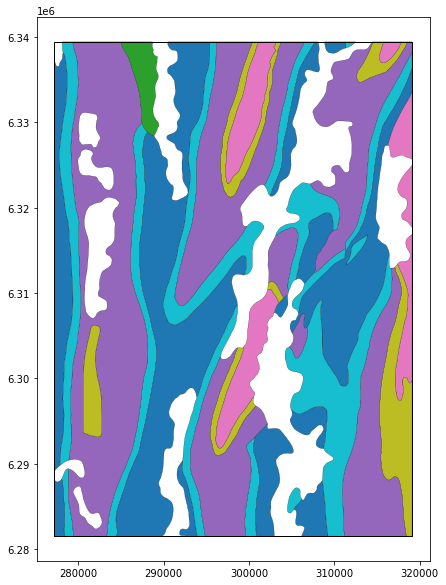

In [93]:
print(geology_file)
geology_ll = gpd.read_file(geology_file,bbox=bbox)

geology_ll[c_l['g']].fillna(geology_ll[c_l['g2']], inplace=True)
geology_ll[c_l['g']].fillna(geology_ll[c_l['c']], inplace=True)
display(geology_ll.head())
base=geology_ll.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')


## Save geology to file as WKT

In [21]:
hint_flag=False # use GSWA strat database to provide relative age hints
def unique_list(list1): 
      
    # insert the list to the set 
    list_set = set(list1) 
    # convert the set to the list 
    return(list(list_set)) 
list1=['geometry', c_l['o'],c_l['c'],c_l['g'],c_l['u'],c_l['min'],c_l['max'],c_l['ds'],c_l['r1'],c_l['r2']]
list2=unique_list(list1)

sub_geol = geology_ll[list2]
m2l_topology.save_geol_wkt(sub_geol,geology_file_csv, c_l,hint_flag)

39  polygons


## Save mineral deposits to file as WKT
This is not needed by map2loop to build 3D models, but is used by map2model to calculate mineral deposit/topology analyses.

0  points


C:\Users\00073294\Anaconda3\envs\loop\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


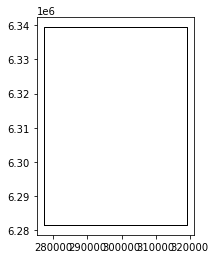

In [22]:
mindep = gpd.read_file(mindep_file,bbox=bbox)

sub_mindep = mindep[['geometry', c_l['msc'],c_l['msn'],c_l['mst'],c_l['mtc'],c_l['mscm'],c_l['mcom']]]
m2l_topology.save_mindep_wkt(sub_mindep,mindep_file_csv, c_l)

base=sub_mindep.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Read and save orientations data point data as WKT

192  points


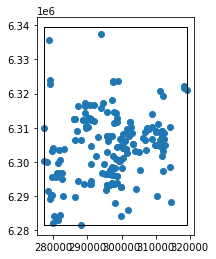

In [23]:
orientations = gpd.read_file(structure_file,bbox=bbox)

sub_pts = orientations[['geometry', c_l['gi'],c_l['d'],c_l['dd']]]

m2l_topology.save_structure_wkt(sub_pts,structure_file_csv,c_l)

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

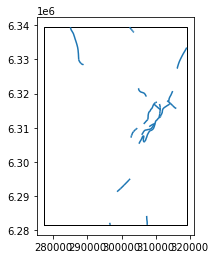

In [24]:
if(os.path.exists(fault_file)):
    lines_ll=gpd.read_file(fault_file,bbox=bbox)

    sub_lines = lines_ll[['geometry', c_l['o'],c_l['f']]]
    base=sub_lines.plot()
    polygon.plot(ax=base, color='none',edgecolor='black')
else:
    sub_lines=[]


## Save faults to file as WKT

In [25]:
m2l_topology.save_faults_wkt(sub_lines,fault_file_csv,c_l)

46  polylines


## Create map2model input file

In [26]:
m2l_topology.save_Parfile(m2m_cpp_path,c_l,graph_path,geology_file_csv,fault_file_csv,structure_file_csv,mindep_file_csv,minx,maxx,miny,maxy,500.0,'Fe,Cu,Au,NONE',2)


## Calculate topology

In [27]:
import subprocess
import platform
os.chdir(m2m_cpp_path)
print(os.getcwd())
#%system map2model.exe Parfile
if(platform.system()=='Windows'):
    subprocess.run(["map2model.exe", "Parfile"])
else:
    subprocess.run(["./map2model", "Parfile"])

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\m2m_cpp


## Simple network graph of the geology with legend   
If in Australia we can use data derived from the ASUD database to refine stratigraphic relationshipsle network graph of the geology with legend

In [28]:
if(Australia):
    asud_strat_file='../source_data/ASUD.csv'
    m2l_topology.use_asud(strat_graph_file, asud_strat_file,graph_path)
    strat_graph_file=graph_path+'ASUD_strat.gml'


0    'Heysen Supergroup'
1    'Warrina Supergroup'
2    'Burra Group'
3    'Umberatana Group'
4    'Wilpena Group'
5    'Yerelina Subgroup'
6    'Yudnamutana Subgroup'


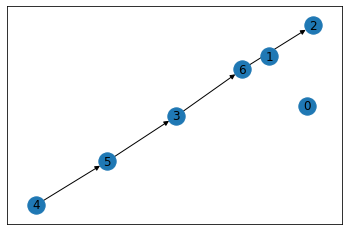

In [29]:
G=nx.read_gml(strat_graph_file,label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        elem=elem.replace(", 'anchor': 'n', 'fontStyle': 'bold'","")
        print(no[0]," ",elem)

## Process topography, stratigraphy, fold axial traces and faults

### Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations:  no dykes, no sills. Sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text to function<br>
Structure layer needs dip/dip direction<br>




In [30]:
os.chdir('../map2loop')

print(os.getcwd())

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

sys.path.insert(0,"../..")
print(os.getcwd())


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Next we define an area of interest and some other basic stuff

In [31]:
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Download and reproject the appropriate SRTM data
mj: Getting this from GA, but could also get from Hawaii

138.55434380574636 139.10713166174568 -33.63561903267695 -33.015865233077285
Attempt: 0 dtm geotif saved as ../SA/dtm/dtm.tif

reprojected dtm geotif saved as ../SA/dtm/dtm_rp.tif


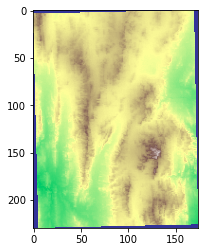

In [32]:
polygon_ll=polygon.to_crs(src_crs)

minlong=polygon_ll.total_bounds[0]-step_out
maxlong=polygon_ll.total_bounds[2]+step_out
minlat=polygon_ll.total_bounds[1]-step_out
maxlat=polygon_ll.total_bounds[3]+step_out

print(minlong,maxlong,minlat,maxlat)
downloaded = False
i=0
print('Attempt: 0 ',end='')
while downloaded == False:
    try:
        m2l_utils.get_dtm(dtm_file, minlong,maxlong,minlat,maxlat)
        downloaded=True
    except:
        time.sleep(10)
        i=i+1
        print(' ',i,end='')
if(i==100):
    raise NameError('map2loop error: Could not access DTM server after 100 attempts')
print()

geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)

dtm = rasterio.open(dtm_reproj_file)
pyplot.imshow(dtm.read(1), cmap='terrain',vmin=0,vmax=1000)
pyplot.show()



## Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.

In [33]:
groups,glabels,G = m2l_topology.get_series(strat_graph_file,'id')
print(groups,glabels)

2 {0: 'Heysen_Supergroup', 1: 'Warrina_Supergroup'}


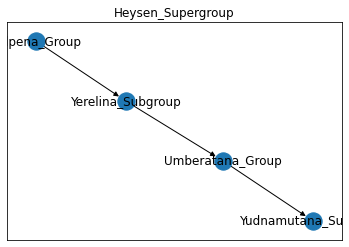

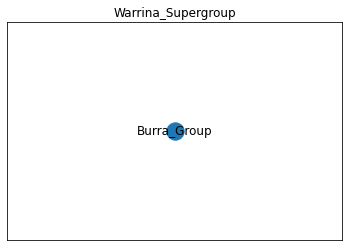

In [34]:
m2l_topology.save_units(G,tmp_path,glabels,Australia,asud_strat_file)


## Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

../SA/tmp/faults_clip.shp


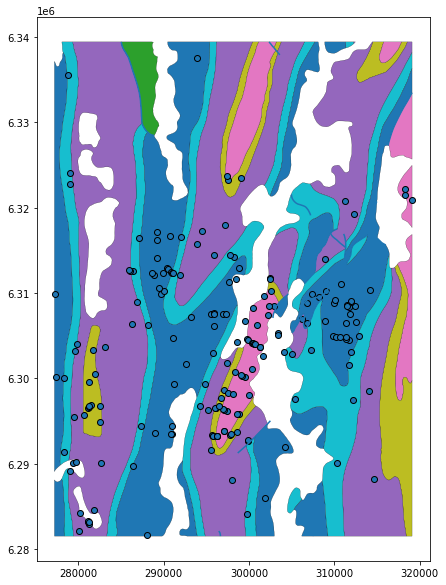

In [35]:
# Extract point data from structure & geology layers for modelling
##First we readin the structure and map from shapefiles, or wherever...

bbox=(minx,miny,maxx,maxy)
geology = gpd.read_file(geology_file,bbox=bbox)
geology[c_l['g']].fillna(geology[c_l['g2']], inplace=True)
geology[c_l['g']].fillna(geology[c_l['c']], inplace=True)


structure = gpd.read_file(structure_file,bbox=bbox)
structure.crs=dst_crs
print(fault_file)
if(os.path.exists(fault_file)):
    faults_clip = gpd.read_file(fault_file,bbox=bbox)
    faults_clip.crs=dst_crs

list1=['geometry',c_l['d'],c_l['dd'],c_l['sf'],c_l['bo']]
list2=unique_list(list1)
       
sub_pts = structure[list2] 

base=geology.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
sub_pts.plot(ax=base,edgecolor='black')
faults_clip.plot(ax=base, column=c_l['f'],edgecolor='black')

## Join geology and structures, save fold axial traces

In [36]:
geol_clip = m2l_utils.explode(geology)
geol_clip.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
structure_code = gpd.sjoin(sub_pts, geol_clip, how="left", op="within")


In [37]:
y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
is_bed=structure_code[c_l['sf']].str.contains(c_l['bedding'], regex=False) 
    
structure_clip = structure_code[is_bed]
structure_clip.crs = dst_crs


if(c_l['otype']=='strike'):
    structure_clip['azimuth2'] = structure_clip.apply(lambda row: row[c_l['dd']]+90.0, axis = 1)
    c_l['dd']='azimuth2'
    c_l['otype']='dip direction'
    
structure_clip=structure_clip[~structure_clip[c_l['o']].isnull()]

structure_clip.to_file(tmp_path+'structure_clip.shp')

## Create possible stratigraphy sets per group
mj: <font color='red'>Uses first of each possible set of toplogies per unit and per group, which is arbitrary. </font>On the other hand we are not checking relative ages again to see if this helps reduce ambiguity, which I think it would.

,index,min,max,ave
group_,,,,
Heysen_Supergroup,0,5.0,8.0,6.5
Warrina_Supergroup,1,9.0,11.0,10.0


[]

{0: 'Heysen_Supergroup', 1: 'Warrina_Supergroup'}

group choices: 1


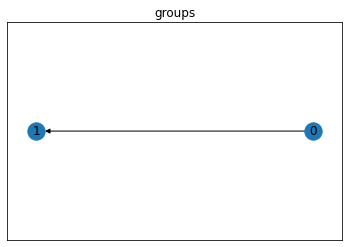

In [38]:
m2l_topology.save_group(G,tmp_path,glabels,geol_clip,c_l)

## Calculate cover depth grid and contacts    
Grid is assumed to be of depth below surface   

Also need to cater for case when we only have grid, no shapefile, so need to add a fake horizontal orientation in the middle of the map at average depth.

In [39]:
if(workflow['cover_map']):

    dtm = rasterio.open(dtm_reproj_file)
    dtb_raw = rasterio.open(dtb_grid)

    cover=gpd.read_file(cover_map_path)

    with fiona.open(cover_map_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(dtb_grid) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta.copy()

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(dtb_clip, "w", **out_meta) as dest:
        dest.write(out_image)  

    dtb = rasterio.open(dtb_clip)
    
    m2l_geometry.process_cover(output_path,dtm,dtb,dtb_null,cover,workflow['cover_map'],cover_dip,bbox,dst_crs,cover_spacing,contact_decimate=3,use_vector=True,use_grid=True)    
    

## Export orientation data in csv  format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. To calculate polarity <font color='red'>(WHICH WE DON'T DO YET)</font> we can calculate the dot product of the dip direction of a bedding plane and the vector to that points nearest basal contact node, if  abs(acos(dot product))>90  then right way up?



Added code to not save intrusion orientation data as they won't have associated surfaces if sill...

177 orientations saved to ../SA/output/orientations.csv


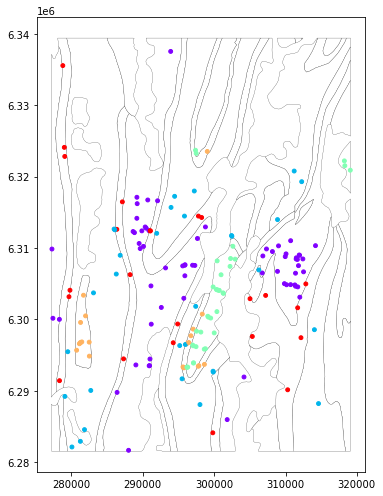

In [40]:
m2l_geometry.save_orientations(structure_clip,output_path,c_l,orientation_decimate,dtm,dtb,dtb_null,workflow['cover_map'])

m2l_utils.plot_points(output_path+'orientations.csv',geol_clip, 'formation','X','Y',False,'alpha')

## Find those series that don't have any orientation or contact point data  then create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)

In [41]:
m2l_geometry.create_orientations( tmp_path, output_path, dtm,dtb,dtb_null,workflow['cover_map'],geol_clip,structure_clip,c_l)

extra orientations saved as ../SA/output//empty_series_orientations.csv


## Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.


<img src='../graphics/base.png'>

In [42]:
ls_dict,ls_dict_decimate=m2l_geometry.save_basal_contacts(tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],geol_clip,contact_decimate,c_l,intrusion_mode)

basal contacts saved allpts= 2912 deci_pts= 684
saved as ../SA/tmp/all_contacts.csv and ../SA/tmp/contacts.csv


## Remove all basal contacts that are defined by faults and save to shapefile (no decimation)

In [43]:
m2l_geometry.save_basal_no_faults(tmp_path+'basal_contacts.shp',tmp_path+'faults_clip.shp',ls_dict,10,c_l,dst_crs)

basal contacts without faults saved as ../SA/tmp/basal_contacts.shp


## Remove faults from decimated basal contacts as save as csv file

decimated contacts saved as ../SA/output/contacts4.csv


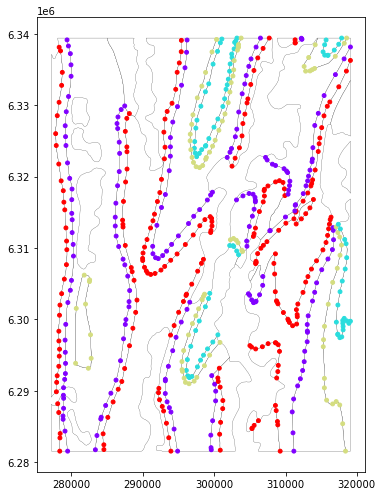

In [44]:
contacts=gpd.read_file(tmp_path+'basal_contacts.shp')

m2l_geometry.save_basal_contacts_csv(contacts,output_path,dtm,dtb,dtb_null,workflow['cover_map'],contact_decimate,c_l)

m2l_utils.plot_points(output_path+'contacts4.csv',geol_clip, 'formation','X','Y',False,'alpha')


## New interpolation test
Interpolates a regular grid of orientations from an  shapefile of arbitrarily-located points and saves out four csv files of l,m & n direction cosines and dip dip direction data

Can choose between various RBF and IDW options   
  
The purpose of these interpolations and associated code is to help in four cases:
- Providing estimated dips and contacts in fault-bounded domains where no structural data are available
- Needed to estimate true thickness of formations
- Estimating fault offset
- Possibly useful for populating parts of maps where little structural data is available

In [45]:
basal_contacts=tmp_path+'basal_contacts.shp'

orientation_interp,contact_interp,combo_interp=m2l_interpolation.interpolation_grids(geology_file,structure_file,basal_contacts,bbox,spacing,dst_crs,scheme,super_groups,c_l)


['Warrina Supergroup'] has no contacts


In [46]:
f=open(tmp_path+'interpolated_orientations.csv','w')
f.write('X,Y,l,m,n,dip,dip_dir\n')
for row in orientation_interp:
    ostr='{},{},{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4],row[5],row[6])
    f.write(ostr)
f.close()
f=open(tmp_path+'interpolated_contacts.csv','w')
f.write('X,Y,l,m,angle\n')
for row in contact_interp:
    ostr='{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4])
    f.write(ostr)
f.close()
f=open(tmp_path+'interpolated_combined.csv','w')
f.write('X,Y,l,m,n,dip,dip_dir\n')
for row in combo_interp:
    ostr='{},{},{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4],row[5],row[6])
    f.write(ostr)
f.close()

201 277
interpolated dips


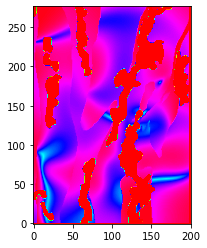

In [47]:
if(spacing<0):
    spacing=-(bbox[2]-bbox[0])/spacing
x=int((bbox[2]-bbox[0])/spacing)+1
y=int((bbox[3]-bbox[1])/spacing)+1
print(x,y)
dip_grid=np.ones((y,x))
dip_grid=dip_grid*-999
dip_dir_grid=np.ones((y,x))
dip_dir_grid=dip_dir_grid*-999
contact_grid=np.ones((y,x))
contact_grid=dip_dir_grid*-999
for row in combo_interp:
    r=int((row[1]-bbox[1])/spacing)
    c=int((row[0]-bbox[0])/spacing)
    dip_grid[r,c]=float(row[5])
    dip_dir_grid[r,c]=float(row[6])

for row in contact_interp:
    r=int((row[1]-bbox[1])/spacing)
    c=int((row[0]-bbox[0])/spacing)
    contact_grid[r,c]=float(row[4])

print('interpolated dips')
plt.imshow(dip_grid, cmap="hsv",origin='lower',vmin=-90,vmax=90)  
plt.show()

interpolated dip directions


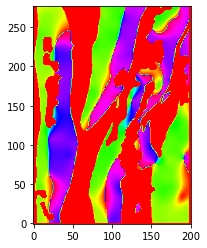

In [48]:
print('interpolated dip directions')
       
plt.imshow(dip_dir_grid, cmap="hsv",origin='lower',vmin=0,vmax=360)    
plt.show()

interpolated contacts


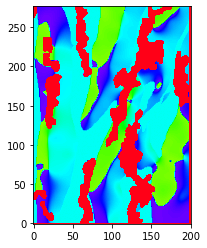

In [49]:
print('interpolated contacts')
       
plt.imshow(contact_grid, cmap="hsv",origin='lower',vmin=-360,vmax=360)    
plt.show()

## Process fault geometry
Save Faults as decimated points and representative orientation  
Then, for each  fault string:
- incementally advance along polyline every at each inter-node (no point in doing more?)
- find local stratigraphy 10m to left and right of fault
  
Once full fault has been traversed:
- Find list of contacts left 
- Find equivalent contacts on right
- use interpolated orientations to estimate minimum true offset assuming vertical displacement and store 
- if no equivalent found, flag as domain fault and find min strat offset for contact, use cumulative minimum thickness estimate and store with flag (not implemented)
- estimate median & sd of minimum fault offset and store with flag (not implemented)

Local Orientations
Since much of the code is the same, we benefit by calculating local orientation data either side of fault so that geomodeller/gempy have satisfied fault compartment orientation data## Save fault as contact info and and orientation info make vertical (for the moment)

In [50]:
 m2l_geometry.save_faults(tmp_path+'faults_clip.shp',output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fault_decimate,min_fault_length,fault_dip)


fault orientations saved as ../SA/output/fault_orientations.csv
fault positions saved as ../SA/output/faults.csv
fault dimensions saved as ../SA/output/fault_dimensions.csv


In [51]:
import warnings
warnings.filterwarnings('ignore')

if(os.path.exists(fault_file)):
    faults=pd.read_csv(output_path+'faults.csv')
    faults_len=len(faults)

    if(faults_len>0):
        m2l_interpolation.process_fault_throw_and_near_faults_from_grid(tmp_path,output_path,dtm_reproj_file,dtb,dtb_null,workflow['cover_map'],c_l,dst_crs,bbox,
                                                                scheme,dip_grid,dip_dir_grid,x,y,spacing)

fault displacement estimates saved as ../SA/output/fault_displacements3.csv
near-fault orientations saved as ../SA/tmp/ex_f_combo_full.csv
near-fault orientations saved as ../SA/tmp/ex_f_combo_full.csv


## Process plutons

For each instruve but not sill polygon, find older neighbours and store decimated contact points. Also store dipping contact orientations (user defined, just because) with four possible sub-surface configurations:

<b>saucers: \\_+++_/ <br>
batholiths: +++/__ __ _\\+++  <br> 
domes: /‾+++‾\\ <br>
pendants: +++\\_  _/+++ <br>
</b>
  
Saves out orientations and contact points, as well as updated group level stratigraphic column.<br>


In [52]:
bbox=(minx,miny,maxx,maxy)

pluton_dip=str(pluton_dip)

dist_buffer=10

m2l_geometry.process_plutons(tmp_path,output_path,geol_clip,local_paths,dtm,dtb,dtb_null,workflow['cover_map'],pluton_form,pluton_dip,contact_decimate,c_l)



0 Heysen_Supergroup
1 Warrina_Supergroup
pluton contacts and orientations saved as:
../SA/output/ign_contacts.csv
../SA/output/ign_orientations_saucers.csv


## Extract faults and basal contacts of groups from seismic section

In [53]:
if(workflow['seismic_section']):
    seismic_line_file=data_path+'seismic_line_10GA-CP1_rev.shp'   #input geology file (if local)
    seismic_line = gpd.read_file(seismic_line_file) #import map
    seismic_line.plot(figsize=(10,10),edgecolor='#000000',linewidth=0.2) #display map
    display(seismic_line)


    seismic_bbox_file=data_path+'seismic_bbox.shp'   #input geology file (if local)
    seismic_bbox = gpd.read_file(seismic_bbox_file) #import map
    seismic_bbox.set_index('POSITION',inplace=True)

    seismic_interp_file=data_path+'seismic_interp.shp'   #input geology file (if local)
    seismic_interp = gpd.read_file(seismic_interp_file) #import map
    seismic_interp.plot(column='FEATURE',figsize=(10,10),edgecolor='#000000',linewidth=0.5) #display map
    display(seismic_interp)

    surface_cut=2000

    m2l_geometry.extract_section(tmp_path,output_path,seismic_line,seismic_bbox,seismic_interp,dtm,dtb,dtb_null,workflow['cover_map'],surface_cut)

    contacts=pd.read_csv(output_path+'contacts4.csv',",")
    seismic_contacts=pd.read_csv(output_path+'seismic_base.csv',",")
    all_contacts=pd.concat([contacts,seismic_contacts],sort=False)
    all_contacts.to_csv (output_path+'contacts4.csv', index = None, header=True)

    faults=pd.read_csv(output_path+'faults.csv',",")
    seismic_faults=pd.read_csv(output_path+'seismic_faults.csv',",")
    all_faults=pd.concat([faults,seismic_faults],sort=False)
    all_faults.to_csv (output_path+'faults.csv', index = None, header=True)


## Propagate dips along contacts


In [54]:
if(workflow['contact_dips']):
    orientations=pd.read_csv(output_path+'orientations.csv',",")
    contact_dip=70
    contact_orientation_decimate=5
    m2l_geometry.save_basal_contacts_orientations_csv(contacts,orientations,geol_clip,tmp_path,output_path,dtm,dtb,
                            dtb_null,workflow['cover_map'],contact_orientation_decimate,c_l,contact_dip,dip_grid,spacing,bbox)

## Estimate formation thickness and normalised formation thickness

42
546 points saved to ../SA/tmp/raw_contacts.csv
305 thickness estimates saved as ../SA/output/formation_thicknesses.csv
['Yudnamutana_Subgroup' 'Yerelina_Subgroup' 'Umberatana_Group'] already processed
110 min thickness estimates appended to ../SA/output/formation_thicknesses.csv
Yudnamutana_Subgroup 960.0 895.8499618223867
Yerelina_Subgroup 560.0 224.77897061635855
Umberatana_Group 1751.0 826.4475014949666
Wilpena_Group 2334.5 958.5470413297592


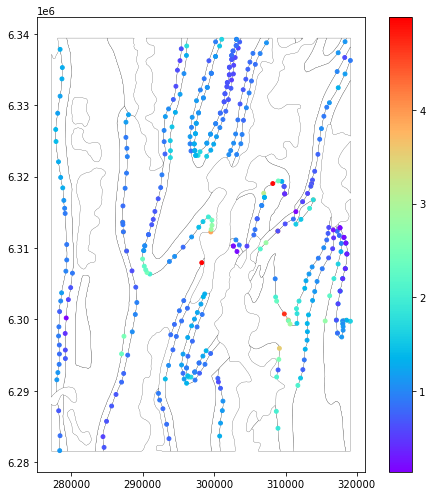

In [55]:
if(workflow['formation_thickness']):

    geology_file=tmp_path+'basal_contacts.shp'
    contact_decimate=5
    null_scheme='null'
    m2l_interpolation.save_contact_vectors(geology_file,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],bbox,c_l,null_scheme,contact_decimate)
    
    buffer =5000
    max_thickness_allowed=10000

    m2l_geometry.calc_thickness_with_grid(tmp_path,output_path,buffer,max_thickness_allowed,
                                          c_l,bbox,dip_grid,dip_dir_grid,x,y,spacing)

    m2l_geometry.calc_min_thickness_with_grid(tmp_path,output_path,buffer,max_thickness_allowed,
                                          c_l,bbox,dip_grid,dip_dir_grid,x,y,spacing)

    m2l_geometry.normalise_thickness(output_path)
    
    m2l_utils.plot_points(output_path+'formation_thicknesses_norm.csv',geol_clip,'norm_th','x','y',True,'numeric')


## Creates fold axial trace points

In [56]:
if(workflow['fold_axial_traces']   and  os.path.exists(fold_file)):
    folds_clip = gpd.read_file(fold_file)
    if(len(folds_clip)>0):
        
        m2l_geometry.save_fold_axial_traces(fold_file,output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fold_decimate)

        #Save fold axial trace near-hinge orientations
        fat_step=750         # how much to step out normal to fold axial trace
        close_dip=70       #dip to assign to all new orientations (-999= use local interpolated dip)

        m2l_geometry.save_fold_axial_traces_orientations(fold_file,output_path,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,dst_crs,
                                                         fold_decimate,fat_step,close_dip,scheme,bbox,spacing,dip_grid,dip_dir_grid)


fold axial traces saved as ../SA/output/fold_axial_traces.csv
fold axial traces saved as ../SA/output/fold_axial_traces.csv
fold axial trace orientations saved as ../SA/output/fold_axial_trace_orientations.csv


## Preprocess data to ensure it meets modelling requirements

In [57]:
m2l_geometry.tidy_data(output_path,tmp_path,clut_path,use_gcode3,use_interpolations,use_fat,pluton_form,inputs,workflow,c_l)
model_top=round(np.amax(dtm.read(1)),-2)
dtm.close()
if(workflow['cover_map']):
    dtb.close()

No contact orientations available for merging.


## Calculate polarity of original bedding orientation data (not used yet in final calc)

In [58]:
if(workflow['polarity']):
    m2l_geometry.save_orientations_with_polarity(output_path+'orientations.csv',output_path,c_l,tmp_path+'basal_contacts.shp',tmp_path+'all_sorts.csv',)

    m2l_utils.plot_points(output_path+'orientations_polarity.csv',geol_clip,'polarity','X','Y',True,'alpha')


## Calculate minimum fault offset from stratigraphy and stratigraphic fault offset

minumim stratigraphic offsets saved as ../SA/output/fault_strat_offset3.csv


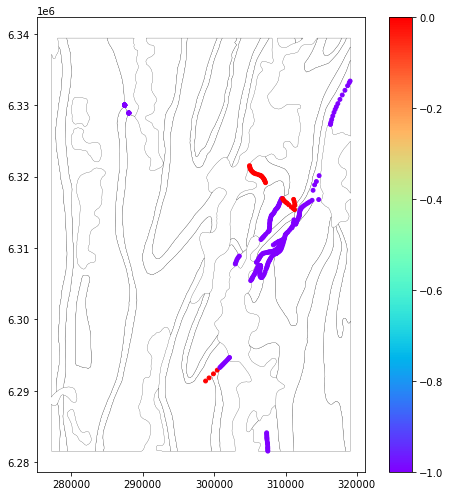

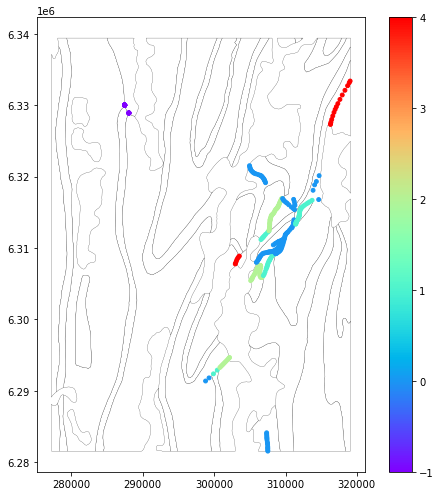

In [59]:
if(workflow['strat_offset'] and os.path.exists(fault_file)):
    fault_test=pd.read_csv(output_path+'fault_dimensions.csv',',')
    if(len(fault_test)>0):

        m2l_geometry.fault_strat_offset(output_path,c_l,dst_crs,output_path+'formation_summary_thicknesses.csv', tmp_path+'all_sorts.csv',tmp_path+'faults_clip.shp',tmp_path+'geol_clip.shp',output_path+'fault_dimensions.csv')


        m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'min_offset','X','Y',True,'numeric')
        m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'strat_offset','X','Y',True,'numeric')

## Analyse fault-fault topology

cycles []


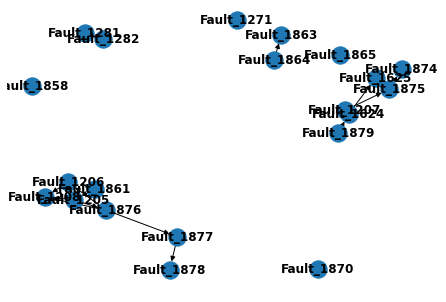

In [60]:
if(os.path.exists(fault_file)):
    m2l_topology.parse_fault_relationships(graph_path,tmp_path,output_path)

# loop2geomodeller test 



In [61]:
if(workflow['model_engine']=='geomodeller'):
    from datetime import datetime
    import shutil

    
    m2l_topology.check_near_fault_contacts(tmp_path+'faults_clip.shp',tmp_path+'all_sorts_clean.csv',
                                           output_path+'fault_dimensions.csv',output_path+'group-fault-relationships.csv',
                                           output_path+'contacts_clean.csv',c_l,dst_crs)

    nowtime=datetime.now().isoformat(timespec='minutes')   
    model_name='leaflet'+'_'+nowtime.replace(":","-").replace("T","-")
    os.mkdir(test_data_path+'/'+model_name)
    save_faults=True
    compute_etc=True
    t1 = time.time()
    m2l_export.loop2geomodeller(model_name,test_data_path,tmp_path,output_path,'../dtm/dtm_rp.tif',bbox,
                                model_top,model_base,save_faults,compute_etc,workflow)
    t2 = time.time()
    os.chdir(test_data_path+'/'+model_name)
    %system geomodellerbatch.exe -batch m2l.taskfile
    t3 = time.time()
    #%system geomodellerbatch.exe -batch m2l_compute.taskfile
    t4 = time.time()
    print("m2l",(t1-t0)/60.0,"export process",(t2-t1)/60.0,"batch process",(t3-t2)/60.0,"batch calculate",(t4-t3)/60.0,"minutes")
    #shutil.copy('../tmp','.')
    #shutil.copy('../output','.')
    #shutil.copy('../graph','.')
    #shutil.copy('../dtm','.')
    os.chdir('..')

# loopstructural test


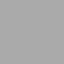

Object exists: supergroup_0_norm_cp
Object exists: supergroup_0_value_cp
m2l 2.771499005953471 LoopStructural 2.359748836358388 Total 5.1312478423118595 minutes


In [62]:
if(workflow['model_engine']=='loopstructural'):
    #model_base=-8200

    import random
    from datetime import datetime
    os.environ['SURFE'] = 'C:/Users/00073294/Dropbox/1_Jupyter_notebooks/surfe/Release/'
    from LoopStructural import GeologicalModel
    import surfepy
    #from LoopStructural import GeologicalModel
    import lavavu
    from LoopStructural.visualisation import LavaVuModelViewer
    from LoopStructural import GeologicalModel
    import logging
    logging.getLogger().setLevel(logging.ERROR)
    import sys
    #sys.path.append('C:/Users/00073294/Dropbox/1_Jupyter_notebooks/surfe/Release/')
    #os.environ['SURFE'] = 'C:/Users/00073294/Dropbox/1_Jupyter_notebooks/surfe/Release/'
    #import surfepy
    
    nowtime=datetime.now().isoformat(timespec='minutes')   
    model_name='leaflet'+'_'+nowtime.replace(":","-").replace("T","-")
    os.mkdir(vtk_path+model_name)
    filename=vtk_path+model_name+'/'+'surface_name_{}.vtk'

    f=open(tmp_path+'bbox.csv','w')
    f.write('minx,miny,maxx,maxy,lower,upper\n')
    ostr='{},{},{},{},{},{}\n'.format(minx,miny,maxx,maxy,model_base,model_top)
    f.write(ostr)
    f.close()
    t1 = time.time()
    fault_params = {'interpolatortype':'FDI',
                    'nelements':3e4,
                    'data_region':.1,
                    'solver':'pyamg',
    #                 overprints:overprints,
                    'cpw':10,
                    'npw':10}
    foliation_params = {'interpolatortype':'PLI' , # 'interpolatortype':'PLI', 'FDI', 'surfe'
                        'nelements':5e5,  # how many tetras/voxels
                        'buffer':0.8,  # how much to extend interpolation around box
                        'solver':'pyamg',
                        'damp':True,
                        'cpw':5}
    
    if(not os.path.exists(fault_file)):
        f=open(output_path + '/fault_displacements3.csv','w')
        f.write('X,Y,fname,apparent_displacement,vertical_displacement,downthrow_dir\n')
        f.close()
        f=open(output_path + '/fault_orientations.csv','w')
        f.write('X,Y,Z,DipDirection,dip,DipPolarity,formation\n')
        f.close()
        f=open(output_path + '/faults.csv','w')
        f.write('X,Y,Z,formation\n')
        f.close()
        f=open(output_path + '/fault-fault-relationships.csv','w')
        f.write('fault_id\n')
        f.close()
        f=open(output_path + '/group-fault-relationships.csv','w')
        f.write('group\n')
        f.close()

        model, m2l_data = GeologicalModel.from_map2loop_directory(test_data_path,
                                                              skip_faults=True,
                                                              fault_params=fault_params,
                                                              foliation_params=foliation_params)
    else:
        model, m2l_data = GeologicalModel.from_map2loop_directory(test_data_path,
                                                              skip_faults=False,
                                                              fault_params=fault_params,
                                                              foliation_params=foliation_params)
  
    view = LavaVuModelViewer(model,vertical_exaggeration=1) 
    view.nsteps = np.array([200,200,200])
    #view.set_zscale(2)
    view.add_model()
    for sg in model.feature_name_index:
        if( 'super' in sg):
            view.add_data(model.features[model.feature_name_index[sg]])
    view.nsteps=np.array([50,50,50])
    view.add_model_surfaces()
    #view.add_model_surfaces(filename=filename)
    view.interactive()  
    
    for sg in model.feature_name_index:
        if( 'super' in sg):
            view.add_data(model.features[model.feature_name_index[sg]])

    t2 = time.time()
    print("m2l",(t1-t0)/60.0,"LoopStructural",(t2-t1)/60.0,"Total",(t2-t0)/60.0,"minutes")

## Overlay map over model

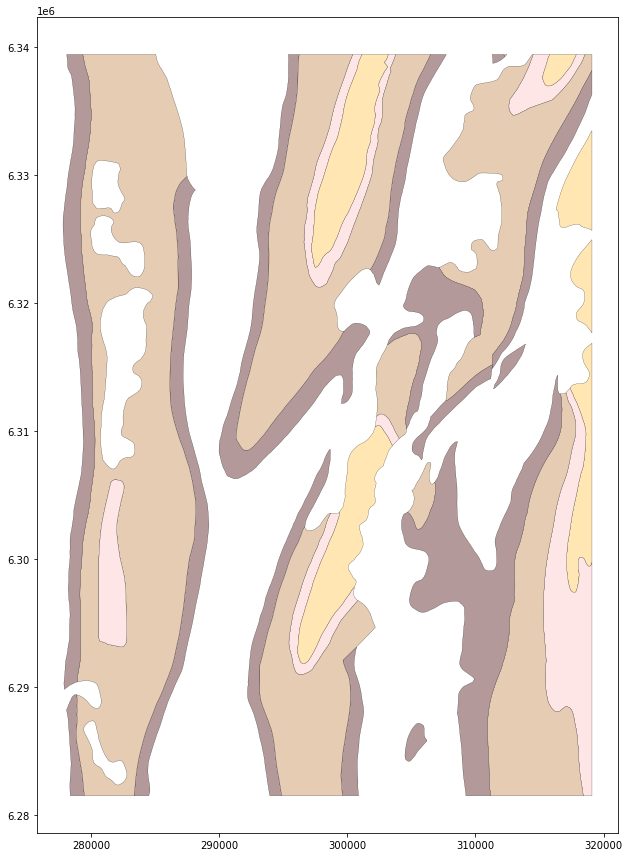

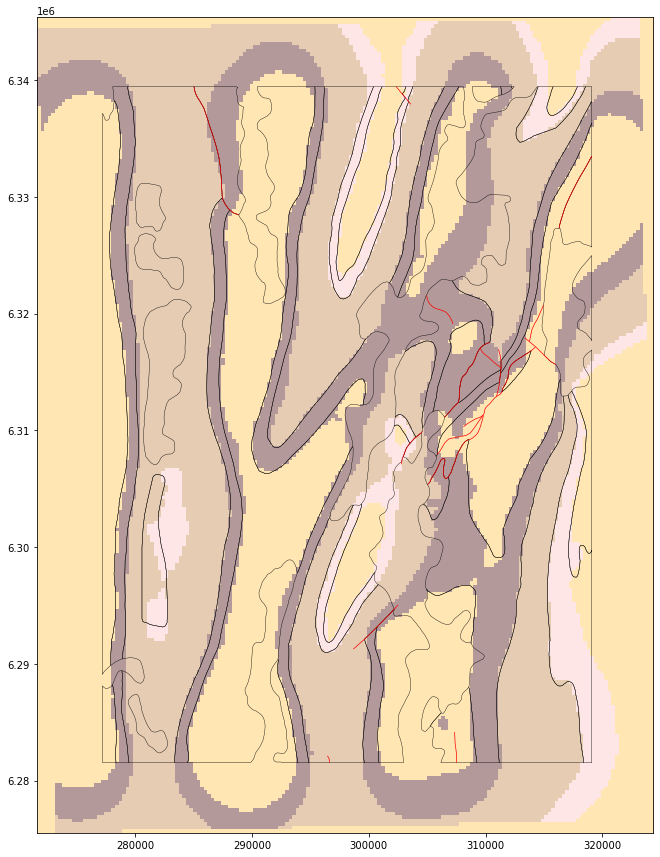

In [65]:
import matplotlib.colors as colors
if(clut_path ==''):
    geol_clip.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2,)
    use_cmap=False
    cmap=0
else:
    use_cmap=True
    asc=pd.read_csv(tmp_path+'all_sorts_clean.csv',",")
    #display(asc)
    colours=pd.read_csv(clut_path,",")
    if( c_l['c']=='CODE'):
        code=c_l['c'].lower()
    else:
        code=c_l['c']

    colours = [] #container for the discrete colours we are using
    i=0
    geol_clip['colour_index'] = np.nan #initialise a colour index attribute column
    for ind,strat in asc.iterrows():
        geol_clip[c_l['c']].str.replace(" ","_")
        geol_clip.loc[geol_clip[c_l['c']]==strat['code'].replace("_"," "),'colour_index'] = i
        colours.append(strat['colour'])
        i=i+1
    
    cmap = colors.ListedColormap(colours) # create a cmap for passing to geopandas
    #display(colours)
    fig, ax = matplotlib.pyplot.subplots(figsize=(15, 15))
    geol_clip.plot(ax=ax,column='colour_index',figsize=(10,10),edgecolor='#000000',linewidth=0.2,cmap=cmap)
    if(workflow['model_engine']=='loopstructural'):  
        dtm = rasterio.open(dtm_reproj_file)
        if(os.path.exists(fault_file)):
            f_clip=faults_clip[faults_clip[c_l['f']].str.contains(c_l['fault'])]
            m2l_export.display_LS_map(model,dtm,geol_clip,f_clip,dst_crs,use_cmap,cmap,use_topo=True,use_faults=True)
        else:
            f_clip=[]
            m2l_export.display_LS_map(model,dtm,geol_clip,f_clip,dst_crs,use_cmap,cmap,use_topo=True,use_faults=False)

        dtm.close()


## Save out voxel model

In [ ]:
if(workflow['model_engine']=='loopstructural'):  
    voxel_size=500
    sizex=int((maxx-minx)/voxel_size)
    sizey=int((maxy-miny)/voxel_size)
    sizez=int((model_top-model_base)/voxel_size)
    print('voxel_size=',voxel_size,', saved in Z,Y,X order, X=',sizex,', Y=',sizey,', Z=',sizez)
    print('lower south west corner: west=',minx,', south=',miny,', lower=',model_base)
    voxels=model.evaluate_model(model.regular_grid(nsteps=(sizey,sizex,sizez),shuffle=False))
    np.savetxt(tmp_path+'voxels.raw', voxels, fmt='%d',delimiter='\t',newline='')
    print('voxels saved as',tmp_path+'voxels.raw')

# gempy test

In [ ]:
if(workflow['model_engine']=='gempy'):

    t1 = time.time()
    import importlib
    importlib.reload(m2l_export)
    import gempy as gp

    vtk = False
    if  vtk:
        vtkexp = gp._plot.export_to_vtk(geo_model, path=vtk_path, name=test_data_name + '.vtk', voxels=False, block=None,
        surfaces=True)
    else:
        m2l_export.loop2gempy(test_data_name,tmp_path,vtk_path,output_path+'orientations_clean.csv',
                                output_path+'contacts_clean.csv',tmp_path+'groups_clean.csv',
                                bbox,model_base, model_top,vtk,dtm_reproj_file)


# noddy test

In [ ]:
if(workflow['model_engine']=='noddy'):

    import pynoddy.history
    import networkx as nx
    #Read a csv file with the vertices of the faults
    #see notes in the bottom of the notebook for instructions on how to generate such vertices files
    t1 = time.time()
    
    scale=1.5 #  scales model to fit predefined volume (complete hack)
    
    # load fault coordinates
    faultsxy=pd.read_csv(output_path+'faults.csv')

    #load fault graph, remove cyclic loops and find (non-unique) age-ordered list 
    G=nx.read_gml(tmp_path+"fault_network.gml")
    cycles=list(nx.simple_cycles(G))
    for c in cycles:
        G.remove_edge(c[0], c[1])
    faults=nx.topological_sort(G)

    # write out Noe format format file
    file=open(tmp_path+'faults_for_noe.csv','w')
    file.write('id,DipDirecti,X,Y\n')
    for f in faults:
            fxy=faultsxy[faultsxy["formation"]==f.replace("\n","")]
            #display(f.replace("\n",""))
            for ind,xy in fxy.iterrows():
                ostr=f.replace('\n','')+',West,'+str(xy['X']/scale)+','+str(xy['Y']/scale)+'\n'
                file.write(ostr)
    file.close()
    
    csvfile = tmp_path+'faults_for_noe.csv'
    CsvFaultData = pd.read_csv(csvfile)

    #how much does the fault slip relative to the fault length
    SlipParam = 0.1

    #the xyz origin of the model you will be generating
    xy_origin=[minx/scale,miny/scale, 1200-4000]

    #Get information about each parameter in Noddy format
    #The output from the function is a dictionary with lists of the fault parameters
    noddyFormattedFaultData =  pynoddy.history.setUpFaultRepresentation(CsvFaultData,
                                                        xy_origin=xy_origin, 
                                                        SlipParam=SlipParam)

    #Create a dictionary with the stratigraphy information
    StratDict = {}
    StratDict['Heights'] = [2000, 2500, 3000, 3700]
    StratDict['Names'] = ['Intrusive', 'Felsic', 'Mafic','Sed'] 
    StratDict['Density'] =  [2.65, 2.5, 2.4, 2.3] 
    StratDict['MagSus'] = [0.0015, 0.0012, 0.0018, 0.001]

    #Now make the history file
    filename = output_path+'faultmodel.his'
    noddyFormattedFaultData =  pynoddy.history.createPyNoddyHistoryFile(noddyFormattedFaultData, StratDict, filename=filename)


In [ ]:
if(workflow['model_engine']=='noddy'):
    import vtkplotter as vtkP
    import itkwidgets
    import k3d
    import pynoddy.output
    import pynoddy.history

    modelfile = output_path+'faultmodel.his'

    # Determine the path to the noddy executable
    noddy_path = '../../pynoddy-new/noddyapp/noddy_win64.exe'

    # Where you would like to place all your output files
    outputfolder = tmp_path

    # choose what software to use for visualizing the model
    #you can also choose to change to itkwidgets, k3d, False (popup), or panel
    #you might need to install packages depending on what you choose
    vtkP.settings.embedWindow('k3d') 

    # create a plot in vtkplotter
    plot = vtkP.Plotter(axes=1, bg='white', interactive=1)

    # call the plotting function
    points = pynoddy.output.CalculatePlotStructure(modelfile, plot, noddy_path, 
                                           outputfolder=outputfolder,
                                           LithologyOpacity=0.2, outputOption=0)
    plot.show(viewup='z')
    t2 = time.time()

    print("m2l",(t1-t0)/60.0,"noddy",(t2-t1)/60.0,"Total",(t2-t0)/60.0,"minutes")
